# Plot figure 1

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


## Data preparation

### Definitions

In [2]:
# dictionary definitions

data_dic = {0: "blds_continents_data_18-23_ai.json",
            1: "blds_africa_states_18-23_ai.json",
            2: "blds_northamerica_states_18-23_ai.json"}
geojson_folder_dic = {0: "geojson-continent-borders",
                      1: "geojson-africa-states",
                      2: "geojson-northamerica-states"}


In [3]:
# user input definition 

while True:
    try:
        user_d_spec = int(input("Which data do you want to plot?\
                            Enter 0 for stats by continents (2018–2023),\
                            1 for stats by Africa states (2018–2023),\
                            2 for stats by North-Central America states (2018–2023)"
                            ))
    except ValueError:
        print("Please enter a number.")
        continue
    if user_d_spec not in range(len(data_dic)):
        print("Please enter 0, 1 or 2.")
        continue
    break


In [4]:
# function definitions

def data_spec(data_dic):
    
    with open(f"downloaded-data\\{data_dic[user_d_spec]}", "r") as f:
        data = json.load(f)
    return data


def get_geojson_names(home_dir, geojson_folder_dic):
    geojson_dir = os.path.join(home_dir, geojson_folder_dic[user_d_spec], "")

    geojson_names = []
    for (dir_path, dir_names, file_names) in os.walk(geojson_dir):  # give the path
        geojson_names.extend(file_names)
    print(geojson_names)
    return geojson_names


### Load the data

In [5]:
os.chdir('..')

data = data_spec(data_dic)

home_dir = os.getcwd()


### Edit the obtained data into desired shape to create a DataFrame

In [6]:
d = {
    "feature": [],
    "source": [],
    "timestamp": [],
    "value": []
}


In [7]:
for cont in data:
    for dic1 in cont:
        feature, source = dic1["groupByObject"][0], dic1["groupByObject"][1]
        for res in dic1["result"]:
            d["feature"].append(feature)
            d["source"].append(source)
            d["timestamp"].append(res["timestamp"])
            d["value"].append(res["value"])

df = pd.DataFrame(d)
# df

In [8]:
# extract only the year
df["year"] = pd.to_datetime(df["timestamp"]).dt.year

### Append the names of the regions to the DataFrame

In [9]:
# extract the geojson IDs and the names
geojson_names = get_geojson_names(home_dir, geojson_folder_dic)


['0_Burundi.geojson', '10_Djibouti.geojson', '11_Algeria.geojson', '12_Egypt.geojson', '13_Gabon.geojson', '14_Eritrea.geojson', '15_Ghana.geojson', '16_Ethiopia.geojson', '17_Guinea.geojson', '18_Gambia.geojson', '19_Guinea Bissau.geojson', '1_Benin.geojson', '20_Morocco.geojson', '21_Liberia.geojson', '22_Lesotho.geojson', '23_Equatorial Guinea.geojson', '24_Libya.geojson', '25_Madagascar.geojson', '26_Kenya.geojson', '27_Mozambique.geojson', '28_Mauritania.geojson', '29_Niger.geojson', '2_Burkina Faso.geojson', '30_Rwanda.geojson', '31_Western Sahara.geojson', '32_Nigeria.geojson', '33_Sudan.geojson', '34_Malawi.geojson', '35_Namibia.geojson', '36_Senegal.geojson', '37_South Sudan.geojson', '38_Mali.geojson', '39_Somaliland.geojson', '3_Ivory Coast.geojson', '40_Swaziland.geojson', '41_Chad.geojson', '42_Somalia.geojson', '43_Sierra Leone.geojson', '44_Togo.geojson', '45_Tunisia.geojson', '46_Uganda.geojson', '47_United Republic of Tanzania.geojson', '48_South Africa.geojson', '49_Z

In [10]:
geojson_names_2 = geojson_names

id_name_dic = {int(re.search(r'^\d+', k)[0]): re.search(r'\_.+\.', v)[0][1:-1] # using lib RegularExpression to separate the ID number and the state name
                for k, v in zip(geojson_names, geojson_names_2)}
id_name_ser = pd.Series(id_name_dic)
id_name_df = pd.DataFrame(id_name_ser, columns=["name"])
id_name_df = id_name_df.reset_index().rename(columns={"index": "id"})
id_name_df["id"] = id_name_df["id"].astype(int)
# id_name_df


In [11]:
# merge df with region names based on IDs
df = df.merge(id_name_df, how="left", left_on="feature",
               right_on="id")
# df.head(20)

### Filtering the data

In [12]:
# get the number of AI Microsoft (source=microsoft/BuildingFootprints) / manually mapped (remainder) buildings for every year
grouped = df.groupby(["source", "year"])["value"].sum()
# grouped

In [13]:
grouped


source                               year
remainder                            2018    28373320.0
                                     2019    43030843.0
                                     2020    52826224.0
                                     2021    65448902.0
                                     2022    77853948.0
                                     2023    90070824.0
source=microsoft/BuildingFootprints  2018           0.0
                                     2019           0.0
                                     2020           0.0
                                     2021      218928.0
                                     2022      268024.0
                                     2023     2574056.0
Name: value, dtype: float64

In [14]:
# merge the DataFrame with groupBy DataFrame and compute the percentage
merged_data = df.merge(grouped, on=["source", 'year'], how='left', )
merged_data = merged_data.rename(columns={"value_x":"num_of_blds", "value_y":"total_blds"})
merged_data["percentage"] = (merged_data["num_of_blds"] / merged_data["total_blds"]) * 100
# merged_data.head(10)


In [15]:
# percentage verification
merged_data.groupby(["source", "year"])["percentage"].sum()


source                               year
remainder                            2018    100.0
                                     2019    100.0
                                     2020    100.0
                                     2021    100.0
                                     2022    100.0
                                     2023    100.0
source=microsoft/BuildingFootprints  2018      0.0
                                     2019      0.0
                                     2020      0.0
                                     2021    100.0
                                     2022    100.0
                                     2023    100.0
Name: percentage, dtype: float64

In [16]:
# create the dataframe by the source
df_ai = merged_data.loc[(df["source"] == "source=microsoft/BuildingFootprints") , :] # buiildings used from Microsoft AI
df_rem = merged_data.loc[(df["source"] == "remainder"),:] # remainder = manually mapped buildings
# df_ai.head()


In [17]:
# how the DataFrame looks like – manually mapped buildings
df_rem.head()


,feature,source,timestamp,num_of_blds,year,id,name,total_blds,percentage
0,0,remainder,2018-01-01T00:00:00Z,63257.0,2018,0,Burundi,28373320.0,0.222945
1,0,remainder,2019-01-01T00:00:00Z,82349.0,2019,0,Burundi,43030843.0,0.191372
2,0,remainder,2020-01-01T00:00:00Z,177419.0,2020,0,Burundi,52826224.0,0.335854
3,0,remainder,2021-01-01T00:00:00Z,371148.0,2021,0,Burundi,65448902.0,0.567081
4,0,remainder,2022-01-01T00:00:00Z,544453.0,2022,0,Burundi,77853948.0,0.699326


In [18]:
# how the DataFrames look like – AI Microsoft buildings
df_ai.head()

,feature,source,timestamp,num_of_blds,year,id,name,total_blds,percentage
6,0,source=microsoft/BuildingFootprints,2018-01-01T00:00:00Z,0.0,2018,0,Burundi,0.0,NaN
7,0,source=microsoft/BuildingFootprints,2019-01-01T00:00:00Z,0.0,2019,0,Burundi,0.0,NaN
8,0,source=microsoft/BuildingFootprints,2020-01-01T00:00:00Z,0.0,2020,0,Burundi,0.0,NaN
9,0,source=microsoft/BuildingFootprints,2021-01-01T00:00:00Z,0.0,2021,0,Burundi,218928.0,0.000000
10,0,source=microsoft/BuildingFootprints,2022-01-01T00:00:00Z,17.0,2022,0,Burundi,268024.0,0.006343


## Plots

In [19]:
def fill_under_lines(*argv, alpha=.2, **kwargs):
    for ax in argv:
        if ax is None:
            ax = plt.gca()
        for line in ax.lines:
            x, y = line.get_xydata().T
            ax.fill_between(x, 0, y, color=line.get_color(), alpha=alpha, **kwargs)

In [20]:
# prepare DataFrame of labels to the end of lines

df_last_rem = df_rem.groupby("name")[["num_of_blds", "year"]].last().reset_index()
df_last_ai = df_ai.groupby("name")[["num_of_blds", "year"]].last().reset_index()
# df_last_rem

### Manually mapped buildings

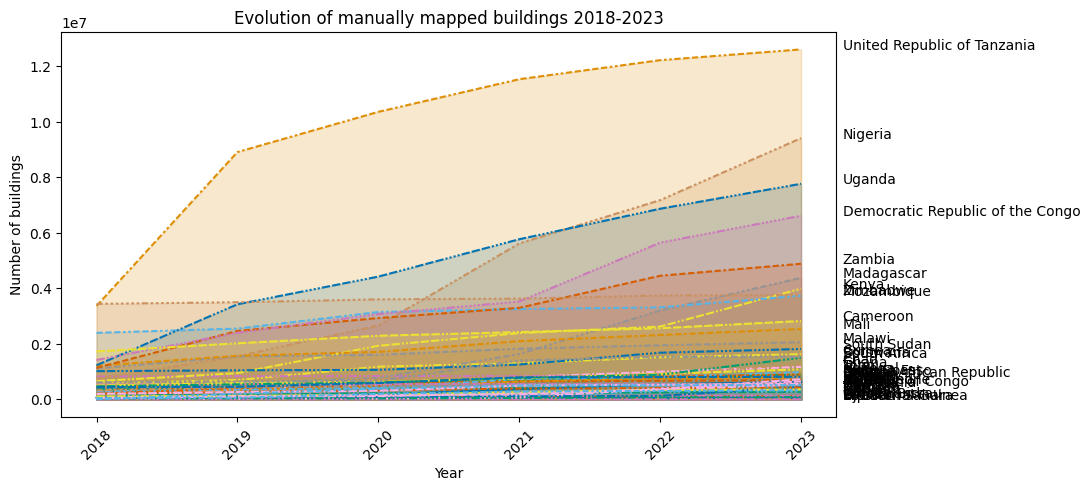

In [21]:
# test for labels at the line

plt.figure(figsize=(10, 5))
plt.title("Evolution of manually mapped buildings 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='num_of_blds', hue='name', data=df_rem,
                  palette='colorblind',  style='name', legend=False
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# add number annotations
# for index, row in df_rem.iterrows():
#     ax.annotate(round(row['num_of_blds']),
#                 (row['year'], row['num_of_blds']))

# add annotations in the end of the lines
for i in range(len(df_last_rem)):
    ax.annotate(df_last_rem.iloc[i]['name'], xy=(df_last_rem.iloc[i]["year"], df_last_rem.iloc[i]
                ['num_of_blds']), xytext=(30, 0), textcoords='offset points', color='black',)

# add colorful annotation
# for line, name in zip(ax.lines, df_last_rem["name"]):
#     y = line.get_ydata()[-1]
#     ax.annotate(name, xy=(1, y), xytext=(1, 0), color=line.get_color(),
#                 xycoords=ax.get_yaxis_transform(), textcoords="offset points",
#                 size=14, va="center")


# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Number of buildings")

plt.show()


Text(0, 0.5, 'Number of buildings')

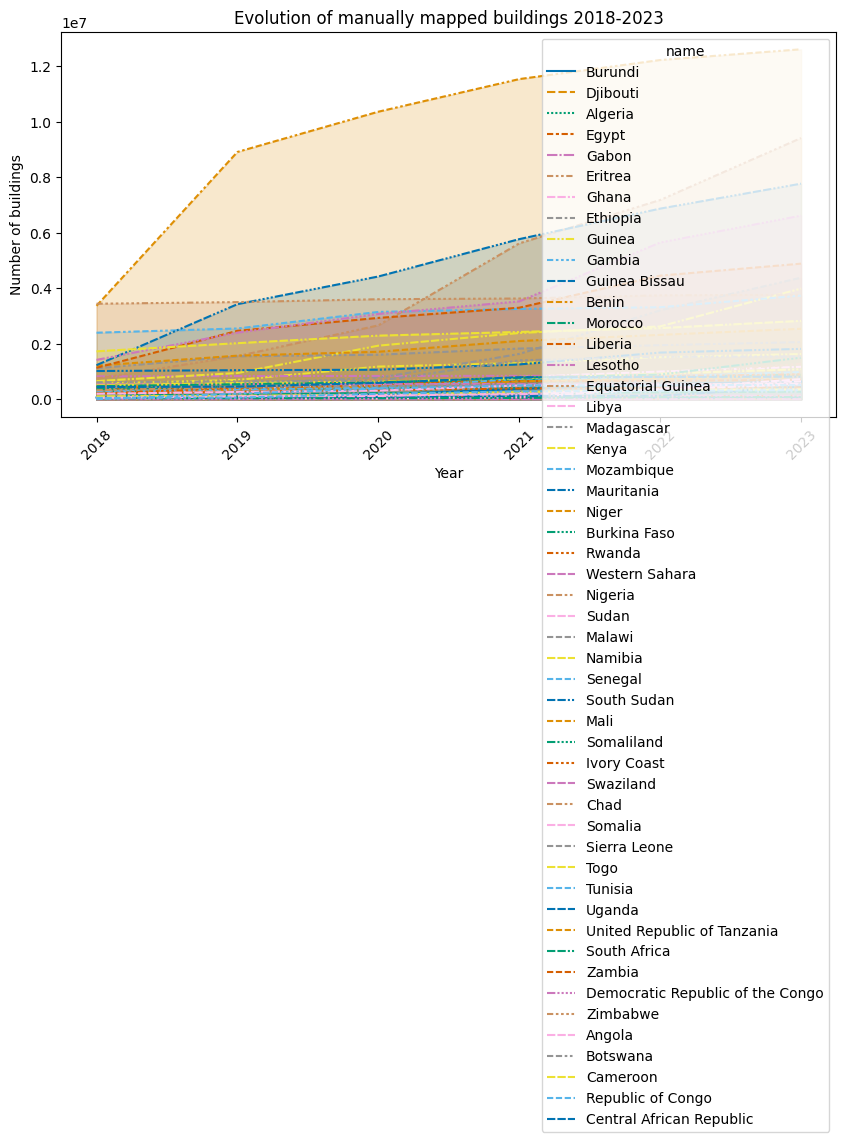

In [22]:
# without dictionary labels

plt.figure(figsize=(10, 5))
plt.title("Evolution of manually mapped buildings 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='num_of_blds', hue='name', data=df_rem,
                  palette='colorblind',  style='name',
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Number of buildings")


### AI Microsoft buildings

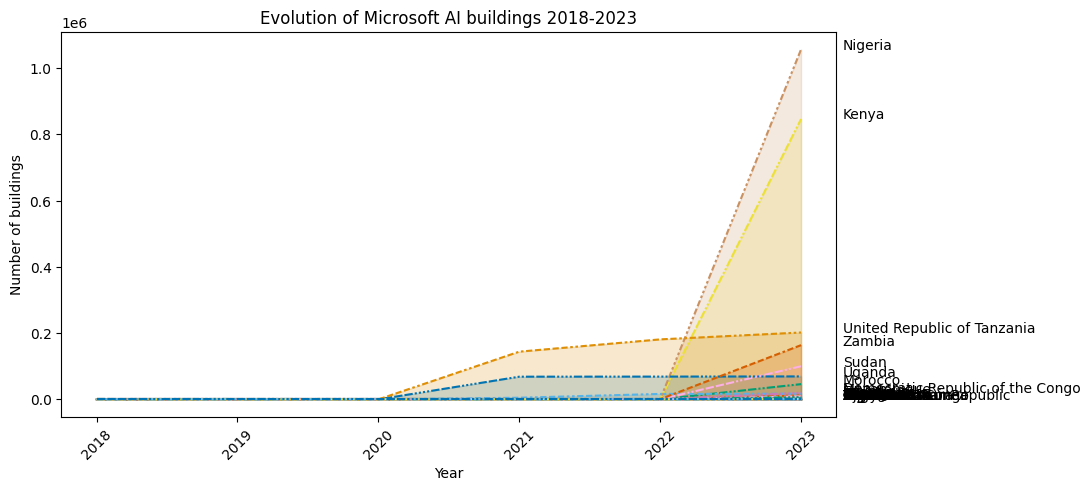

In [23]:
# test for labels at the line

plt.figure(figsize=(10, 5))
plt.title("Evolution of Microsoft AI buildings 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='num_of_blds', hue='name', data=df_ai,
                  palette='colorblind',  style='name', legend=False
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# add annotations in the end of the lines
for i in range(len(df_last_ai)):
    ax.annotate(df_last_ai.iloc[i]['name'], xy=(df_last_ai.iloc[i]["year"], df_last_ai.iloc[i]
                ['num_of_blds']), xytext=(30, 0), textcoords='offset points')


# add colorful annotation
# for line, name in zip(ax.lines, df_last_ai["name"]):
#     y = line.get_ydata()[-1]
#     ax.annotate(name, xy=(1, y), xytext=(1, 0), color=line.get_color(),
#                 xycoords=ax.get_yaxis_transform(), textcoords="offset points",
#                 size=14, va="center")


# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Number of buildings")

plt.show()


Text(0, 0.5, 'Number of buildings')

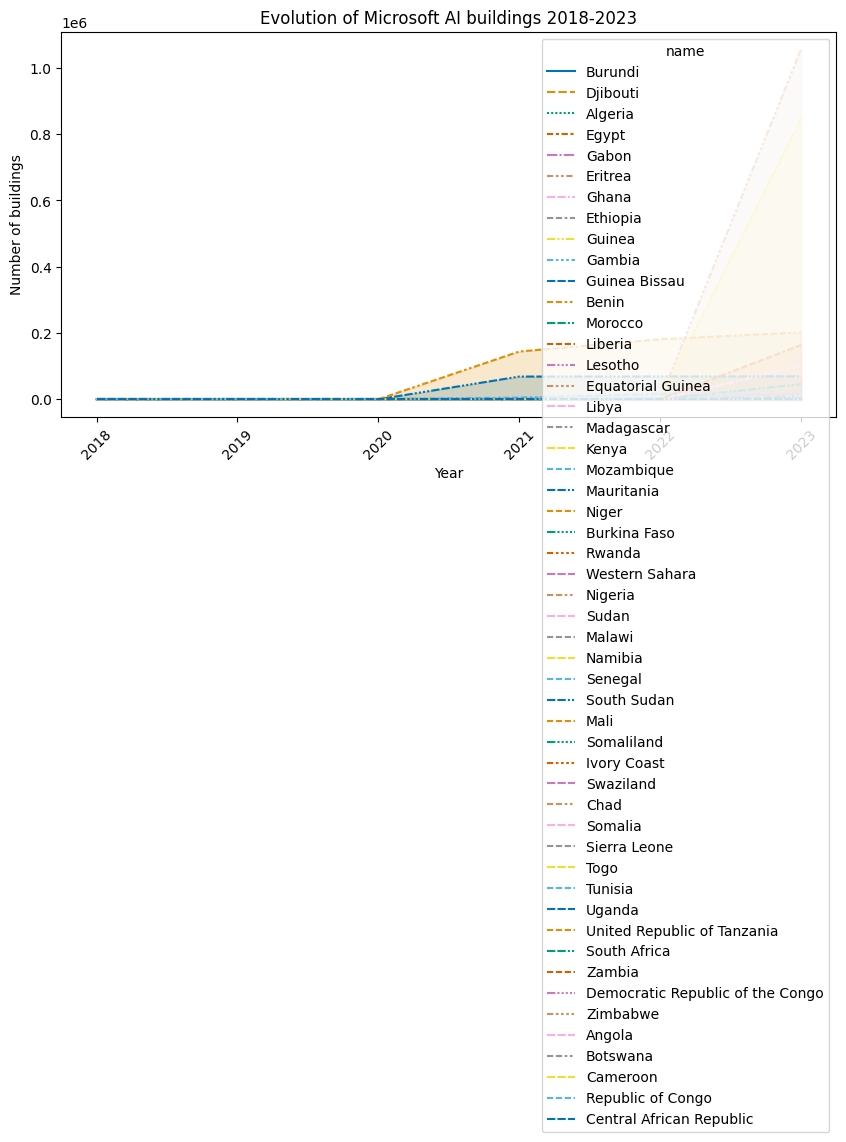

In [24]:
# without dictionary labels

plt.figure(figsize=(10, 5))
plt.title("Evolution of Microsoft AI buildings 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='num_of_blds', hue='name', data=df_ai,
                  palette='colorblind',  style='name',
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Number of buildings")


### AI Microsoft and Manually mapped buildings together

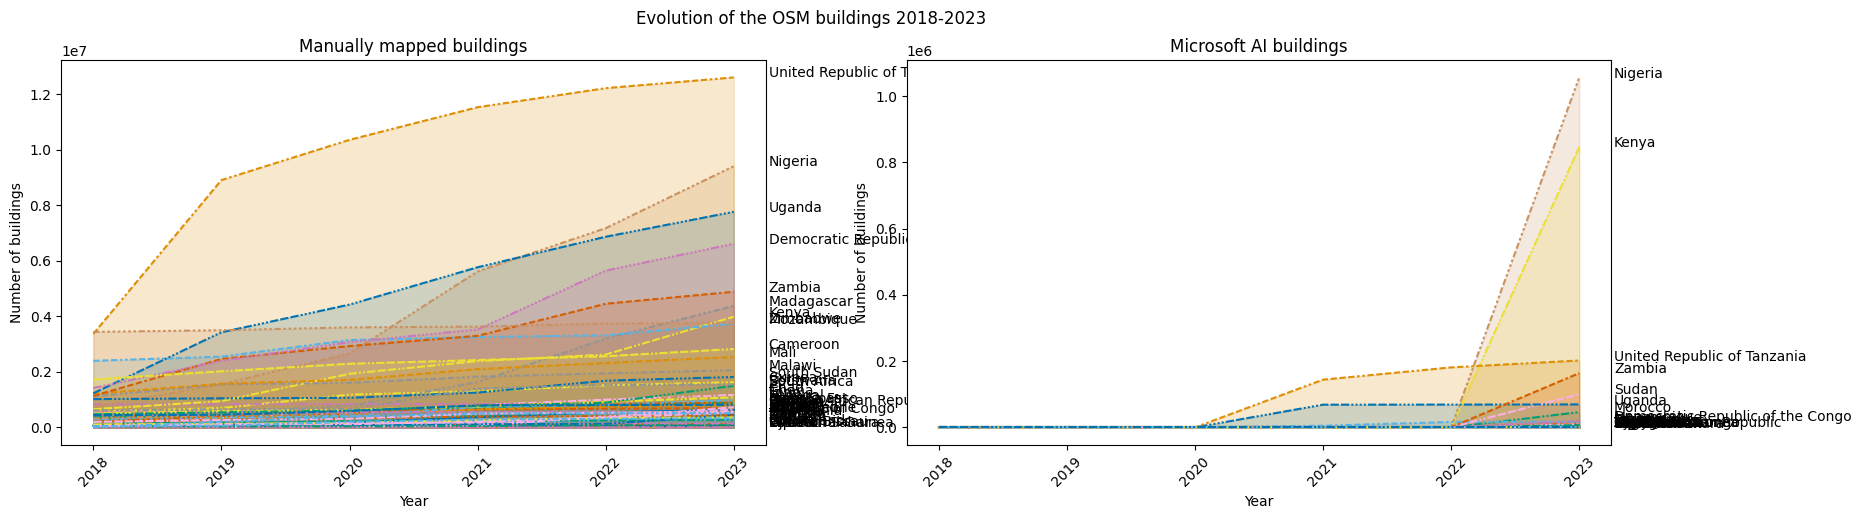

In [25]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
fig.suptitle("Evolution of the OSM buildings 2018-2023")

fig.subplots_adjust(hspace=2)

# create a Seaborn plot on the first subplot
sns.lineplot(x='year', y='num_of_blds', hue='feature', data=df_rem, ax=ax1,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys(),
             legend=False
             )

# create another Seaborn plot on the second subplot
sns.lineplot(x='year', y='num_of_blds', hue='feature', data=df_ai, ax=ax2,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys(),
             legend=False
             )


# ax1.set_yscale("log")
# ax2.set_yscale("log")

# set titles for each subplot
ax1.set_title("Manually mapped buildings")
ax2.set_title("Microsoft AI buildings")

# set the y axis limit
# ax1.set_ylim(top=105, bottom=-5)
# ax2.set_ylim(top=105, bottom=-5)

# set the y axis label
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of buildings")

# set the x axis label
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of buildings")

# fill the area under lines
fill_under_lines(ax1, ax2)

# rotate x-axis labels for both subplots
for ax in [ax1, ax2]:
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.tick_params(axis='x', labelrotation=45)

# add colorful annotation
# for line, name in zip(ax1.lines, df_last_rem["name"]):
#     y = line.get_ydata()[-1]
#     ax1.annotate(name, xy=(1, y), xytext=(1, 0), color=line.get_color(),
#                  xycoords=ax1.get_yaxis_transform(), textcoords="offset points",
#                  size=14, va="center")

# for line, name in zip(ax2.lines, df_last_ai["name"]):
#     y = line.get_ydata()[-1]
#     ax2.annotate(name, xy=(1, y), xytext=(1, 0), color=line.get_color(),
#                  xycoords=ax2.get_yaxis_transform(), textcoords="offset points",
#                  size=14, va="center")



# add annotations in the end of the lines – ax1
for i in range(len(df_last_rem)):
    ax1.annotate(df_last_rem.iloc[i]['name'], xy=(df_last_rem.iloc[i]["year"], df_last_rem.iloc[i]
                ['num_of_blds']), xytext=(25, 0), textcoords='offset points')

# add annotations in the end of the lines – ax2
for i in range(len(df_last_ai)):
    ax2.annotate(df_last_ai.iloc[i]['name'], xy=(df_last_ai.iloc[i]["year"], df_last_ai.iloc[i]
    ['num_of_blds']), xytext=(25, 0), textcoords='offset points')

plt.show()


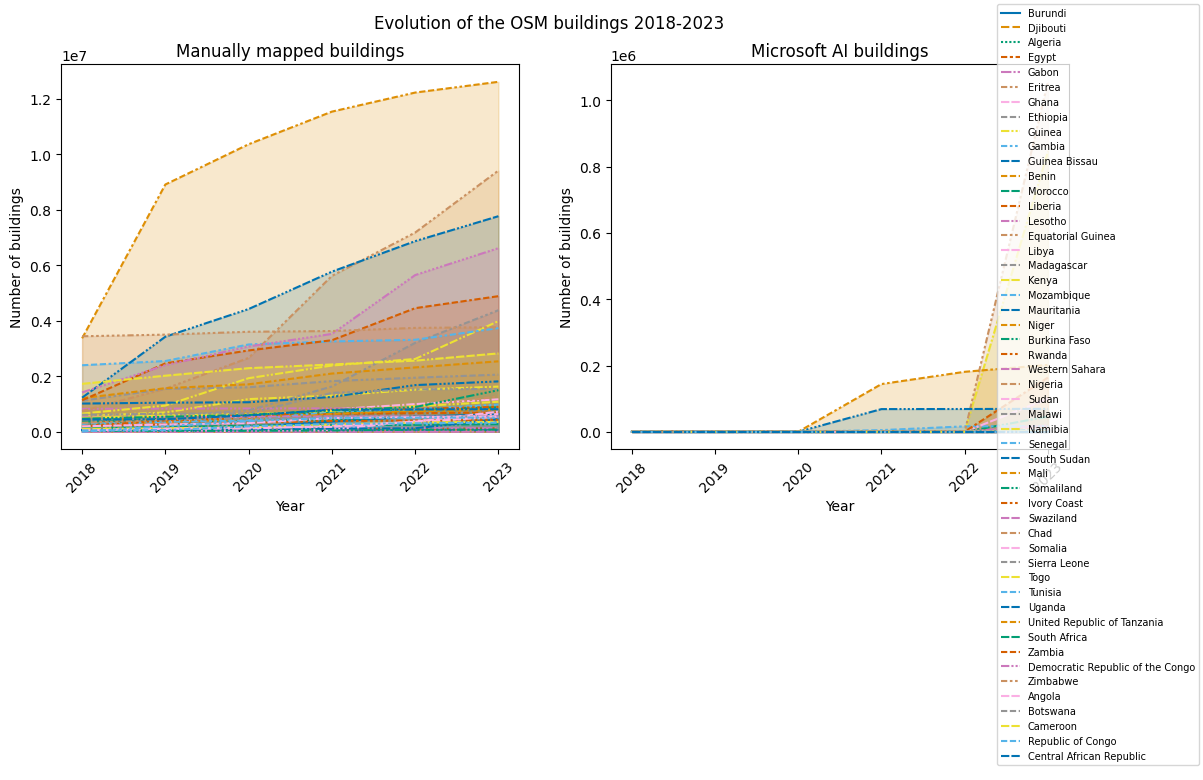

In [26]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5))
fig.suptitle("Evolution of the OSM buildings 2018-2023")

# create a Seaborn plot on the first subplot
sns.lineplot(x='year', y='num_of_blds', hue='feature', data=df_rem, ax=ax1,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys()
             )

# create another Seaborn plot on the second subplot
sns.lineplot(x='year', y='num_of_blds', hue='feature', data=df_ai, ax=ax2,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys())

# set the legend labels
handles, _ = plt.gca().get_legend_handles_labels()
ax2.legend(handles, [id_name_dic[key]
           for key in id_name_dic.keys()], fontsize=7)
ax1.legend().remove()
ax2.legend().remove()

# ax1.set_yscale("log")
# ax2.set_yscale("log")

# set titles for each subplot
ax1.set_title("Manually mapped buildings")
ax2.set_title("Microsoft AI buildings")

# set the y axis limit
# ax1.set_ylim(top=105, bottom=-5)
# ax2.set_ylim(top=105, bottom=-5)

# set the y axis label
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of buildings")

# set the x axis label
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of buildings")

# fill the area under lines
fill_under_lines(ax1, ax2)

# rotate x-axis labels for both subplots
for ax in [ax1, ax2]:
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.tick_params(axis='x', labelrotation=45)

fig.legend(handles, [id_name_dic[key]
           for key in id_name_dic.keys()], fontsize=7)

plt.show()
